# Use case: Movies review sentiment analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !curl
!tar -xf aclImdb_v1.tar.gz

--2023-08-27 11:19:15--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.9MB/s    in 6.8s    

2023-08-27 11:19:22 (11.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import os
import re
import pandas as pd

# Function to load the data
def load_data(directory):
    data = {}
    data["review"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), "r") as file:
            data["review"].append(file.read())
        result = re.search(r"\d+_(\d+)\.txt$", file_path)
        data["sentiment"].append(int(result.group(1)))
    return pd.DataFrame.from_dict(data)



In [ ]:
# Load training data
train_data = load_data("aclImdb/train/pos")
train_data = train_data.append(load_data("aclImdb/train/neg"))

# Load testing data
test_data = load_data("aclImdb/test/pos")
test_data = test_data.append(load_data("aclImdb/test/neg"))

# Print the first 5 rows of the train_data DataFrame
print(train_data.head())

<ipython-input-8-ead8f952d0f4>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(load_data("aclImdb/train/neg"))


                                              review  sentiment
0  Nicely and intelligently played by the two you...         10
1  This will be somewhat short. First, don't list...          9
2  by saying that,I mean that this is not a well ...         10
3  Every time this film is on the BBC somebody in...          8
4  Match 1: Tag Team Table Match Bubba Ray and Sp...          9


<ipython-input-8-ead8f952d0f4>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(load_data("aclImdb/test/neg"))


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [ ]:
train_data = train_data.sample(n=1000, random_state=23)

# 'n' specifies the number of random samples you want to select
# 'random_state' sets a seed for reproducibility (optional)

In [ ]:
train_data.head()

,review,sentiment
3637,Man oh man... I've been foolishly procrastinat...,10
11109,Cheech & Chong's Next Movie (1980) was the sec...,7
7908,It's a bit easy. That's about it.<br /><br />T...,10
4773,I read nothing but good things about this movi...,8
9782,"this movie is outrageous. by outrageous, i mea...",1


## Preprocess the Data

This step might involve text cleaning tasks such as converting text to lower case, removing punctuation, removing HTML tags, tokenization, removing stop words, and stemming or lemmatization.

In [ ]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-11-08c90978dd92>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
def preprocess_data(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()
    # Tokenize the text
    tokens = tokenizer.tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return " ".join(stemmed_tokens)

train_data['review'] = train_data['review'].apply(preprocess_data)
test_data['review'] = test_data['review'].apply(preprocess_data)

In [ ]:
print(train_data.iloc[1, 0])

cheech chong next movi 1980 second film star pot love duo cheech marin tommi chong lovabl burn smoker roommat live condemn build look way score smoke lay day cheech respons one job steadi girlfriend one day cheech want get freak tri get chong hous anoth problem aris well cheech brother red cheech anoth role town want hang firgur could kill two bird one stone cheech pawn chong red kind adventur chong red get cheech get freak long chong go without smoke watch cheech chong next movi find tommi chong take directori reign sequel receiv experi uncredit work smoke funni good first film cheech chong fan enjoy follow nice dream recommend


## Convert Sentiment Scores to Binary Values

Let's consider reviews with a sentiment score greater than or equal to 7 as positive (1) and the rest as negative (0).

In [ ]:
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: 1 if x >= 7 else 0)
test_data['sentiment'] = test_data['sentiment'].apply(lambda x: 1 if x >= 7 else 0)

## Feature Extraction with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(train_data['review'])
X_test = tfidf.transform(test_data['review'])
y_train = train_data['sentiment']
y_test = test_data['sentiment']

In [ ]:
print(y_test.iloc[390])

1


##  Define and Train Models


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

SVM

In [ ]:
from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, y_train)

SVC()

Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
nn = Sequential()
nn.add(Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
32/32 - 1s - loss: 0.6845 - accuracy: 0.6920 - 1s/epoch - 34ms/step
Epoch 2/10
32/32 - 0s - loss: 0.6075 - accuracy: 0.9210 - 124ms/epoch - 4ms/step
Epoch 3/10
32/32 - 0s - loss: 0.5011 - accuracy: 0.9640 - 142ms/epoch - 4ms/step
Epoch 4/10
32/32 - 0s - loss: 0.3945 - accuracy: 0.9910 - 142ms/epoch - 4ms/step
Epoch 5/10
32/32 - 0s - loss: 0.3028 - accuracy: 0.9960 - 154ms/epoch - 5ms/step
Epoch 6/10
32/32 - 0s - loss: 0.2290 - accuracy: 0.9960 - 138ms/epoch - 4ms/step
Epoch 7/10
32/32 - 0s - loss: 0.1745 - accuracy: 0.9960 - 138ms/epoch - 4ms/step
Epoch 8/10
32/32 - 0s - loss: 0.1338 - accuracy: 0.9970 - 150ms/epoch - 5ms/step
Epoch 9/10
32/32 - 0s - loss: 0.1048 - accuracy: 0.9990 - 140ms/epoch - 4ms/step
Epoch 10/10
32/32 - 0s - loss: 0.0830 - accuracy: 0.9990 - 146ms/epoch - 5ms/step


## Evaluate Models

782/782 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     12500
           1       0.82      0.75      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

              precision    recall  f1-score   support

           0       0.85      0.79      0.82     12500
           1       0.80      0.86      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     12500
           1       0.79      0.86      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       

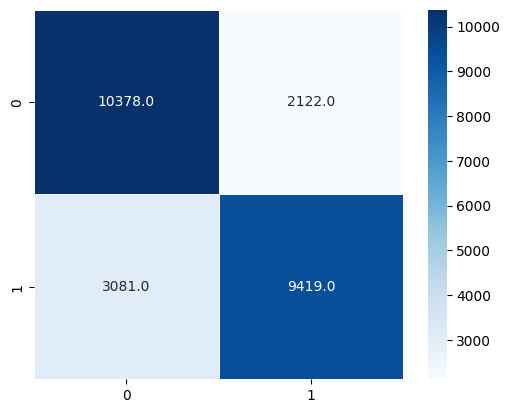

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict values for the test set
rf_pred = rf.predict(X_test)
svc_pred = svc.predict(X_test)
nn_pred = (nn.predict(X_test.toarray()) > 0.5).astype("int32")

# Print classification reports
print(classification_report(y_test, rf_pred))
print(classification_report(y_test, svc_pred))
print(classification_report(y_test, nn_pred))

# Confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues')
plt.show()

# Repeat confusion matrix visualization for other models as needed